In [1]:
# default_exp domains

# Domains

Once the data is loaded, it is important to visualize all of the tests in their relative contexts.
No single tests will hold all of the answers for a domain.

A useful interactive visualization system has the following properties:
 - Handles creating and arranging multiple figures
   - Handle passing raw data to transforms for normalization
   - Handle generating axes
 - Maintains a common data source for linked brushing
 - Can export selections (future)

Let's load in our large dataset and start playing with the full data to workout bugs.

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
#export
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sbn

from autoneuro.calculators import TestCalculator


In [4]:
all_neuro = pd.read_excel('data/neuro_data.xlsx',
                          na_values=['na', '-', 'nd']).groupby(['VisitDate', 'PatientID']).first()
all_neuro.replace({'Race': {2: 'AA',
                            1: 'white',
                            3: 'asian'},
                   'Sex': {1: 'male', 2: 'female'}},
                  inplace=True)

COLUMN_MAPPING = {'BVMTtrial1': 'trial1', 'BVMTtrial2': 'trial2', 'BVMTtrial3': 'trial3',
                  'BVMTdelay': 'delay',
                  'BVMThits': 'hits', 'BVMTfalsepos': 'false_pos',
                  'Stroop.word': 'stroop_word',
                  'Stroop.color': 'stroop_color',
                  'Stroop.colorword': 'stroop_color_word',
                  'Sex': 'gender', 'Race': 'race',
                  'Education': 'education', 'Age': 'age'}

all_neuro.head()


Visit  Age     Sex Race Race_specify  Education  \
VisitDate  PatientID                                                    
2013-09-24 A0091        1.0   36    male   AA          NaN         16   
           A0107        1.0   49  female   AA          NaN         12   
           A0138        1.0   53  female   AA          NaN         11   
2013-10-03 A0165        1.0   62    male   AA          NaN         12   
2013-10-08 A0127        1.0   62    male   AA          NaN         16   

                      EngFluency  SpanFluency  MMSE  DigitBackwardSENAS  ...  \
VisitDate  PatientID                                                     ...   
2013-09-24 A0091             3.0          0.0  27.0                 6.0  ...   
           A0107             3.0          0.0  27.0                 3.0  ...   
           A0138             3.0          0.0   NaN                 NaN  ...   
2013-10-03 A0165             3.0          0.0  29.0                 5.0  ...   
2013-10-08 A0127             3.0          0.0  28.0                 2.0  ...   

                      Professional  Homeowner  Householdsize  Earnings.Indiv  \
VisitDate  PatientID                                                           
2013-09-24 A0091               NaN        NaN            NaN             NaN   
           A0107               NaN        NaN            NaN             NaN   
           A0138               NaN        NaN            NaN             NaN   
2013-10-03 A0165               NaN        NaN            NaN             NaN   
2013-10-08 A0127               NaN        NaN            NaN             NaN   

                      Income.Indiv  Earnings.House  Income.House  \
VisitDate  PatientID                                               
2013-09-24 A0091               NaN             NaN           NaN   
           A0107               NaN             NaN           NaN   
           A0138               NaN             NaN           NaN   
2013-10-03 A0165               NaN             NaN           NaN   
2013-10-08 A0127               NaN             NaN           NaN   

                      Income.House.Weighted1  Income.House.Weighted2  Effort  
VisitDate  PatientID                                                          
2013-09-24 A0091                         NaN                     NaN     1.0  
           A0107                         NaN                     NaN     NaN  
           A0138                         NaN                     NaN     1.0  
2013-10-03 A0165                         NaN                     NaN     NaN  
2013-10-08 A0127                         NaN                     NaN     NaN  

[5 rows x 163 columns]

This system will be built by visualizations which match to specific neurological tests.
These tests will be the base of this system.
In the abstract, a test defines a set of measurement fields and how they relate.
Then it can generate visualization modules both the raw and normalized fields as needed.
A collection of these `TestCalculator` objects will be combined into a `Domain`.

In [5]:
import yaml

bvmt_test_definition = 'data/test_calculators/BVMT.yaml'
bvmt_calc = TestCalculator.from_config(yaml.full_load(open(bvmt_test_definition)))

heaton_norm_definition = 'data/norms/from_kate/heaton_bvmt.yaml'
heaton_bvmt_calc = TestCalculator.from_config(yaml.full_load(open(heaton_norm_definition)))

norman_scaling_definition = 'data/norms/norman/norman_scaling.yaml'
norman_scale = TestCalculator.from_config(yaml.full_load(open(norman_scaling_definition)))

norman_regression_definition = 'data/norms/norman/norman_bvmt_regnorm.yaml'
reg_calc = TestCalculator.from_config(yaml.full_load(open(norman_regression_definition)))

full_bvmt_calc = bvmt_calc + heaton_bvmt_calc + norman_scale + reg_calc




In [6]:
#export
from bokeh.transform import factor_cmap, factor_mark
from bokeh.models import BooleanFilter, CDSView, BoxAnnotation, Band, IndexFilter, BooleanFilter, FactorRange
from bokeh.models import Legend, LegendItem

from bokeh.models import ColumnDataSource, HoverTool, Range1d
from bokeh.plotting import figure
from bokeh.layouts import gridplot, layout
from bokeh.io import show

In [7]:
from bokeh.io import output_notebook, show
output_notebook()

Loading BokehJS ...

Those tests will likely become more complicated and less "abstract" as we go.
But they're enough to represent each test and contain the information we need.

Now that we have a way of representing tests, lets merge them into domains and start visualizing.

In the abstract a domain collection should:
  - Hold the test calculator and hold a list a "defining_tests".
  - Manage the processing of the data with the calculator.
  - Hold Bokeh data like the `ColumnDataSource`, shared ranges, etc.
  - Combine the "defining_test" using an aggregation method.

In [8]:
#export

import os
from itertools import chain
from sklearn.decomposition import TruncatedSVD

class AbstractDomain(object):

    source = None
    data = None
    ranges = {}
    _weights = 1
    tools = "pan,wheel_zoom,box_zoom,reset,box_select,lasso_select"

    def __init__(self, calculator, final_fields, agg_method = 'SVD'):
        """

        Parameters
        ----------
        calculator : TestCalculator
        final_fields : list[str]
        aggmethod : str
        """

        self.calculator = calculator
        self.final_fields = final_fields
        self.agg_method = agg_method

    def _load_data(self):
        pass

    def load_data(self, data, mapping=None):
        self.data = self.calculator.process_dataframe(data, mapping=mapping)
        self._load_data()
        self.aggregate_scores()
        self.source = ColumnDataSource(self.data)

    def build_scatter_fig(self, x = None, y = None,
                          fig = None, scatter_kwargs = None):

        x_range = self.ranges.get(x, Range1d(-10, 10))
        y_range = self.ranges.get(y, Range1d(-10, 10))
        default = {'x_range': x_range, 'y_range': y_range, 'tools': self.tools}
        if fig is None:
            fig = figure(**default)
        elif type(fig) == dict:
            fig = figure(**fig, **default)

        scatter_kwargs = {} if scatter_kwargs is None else scatter_kwargs
        fig.scatter(x = x, y = y, source = self.source,
                    **scatter_kwargs)
        fig.xaxis.axis_label = x
        fig.yaxis.axis_label = y

        self.ranges[x] = fig.x_range
        self.ranges[y] = fig.y_range

        return fig

    def aggregate_scores(self):

        if self.agg_method == 'SVD':
            ndata = self.data[self.final_fields].dropna()
            svd = TruncatedSVD(n_components=1, random_state=12)
            svd.fit(ndata)
            weights = np.abs(svd.components_[0, :]) # Deal with sign
            weights = weights / np.sum(weights) # Deal with scale
            self._weights = pd.Series(weights, index = self.final_fields)

            res = (weights*self.data[self.final_fields].values).sum(axis=1)
        elif self.agg_method == 'mean':
            res = self.data[self.final_fields].mean(axis=1)
        else:
            raise ValueError('Did not understand aggmethod: ' + self.agg_method)

        self.data['aggregated_score'] = res

    def build_aggscore_figures(self, fig = None, scatter_kwargs = None):

        if 'aggregated_score' not in self.data.columns:
            self.aggregate_scores()

        figs = []
        for col in self.final_fields:
            figs.append(self.build_scatter_fig(x = col, y = 'aggregated_score',
                                               scatter_kwargs=scatter_kwargs,
                                               fig=fig))

        return figs



In [9]:
#export


class MemoryDomain(AbstractDomain):


    @staticmethod
    def from_defaults(root_data = 'data/'):

        bvmt_test_definition = os.path.join(root_data, 'test_calculators/BVMT.yaml')
        bvmt_calc = TestCalculator.from_config(yaml.full_load(open(bvmt_test_definition)))

        heaton_norm_definition = os.path.join(root_data, 'norms/from_kate/heaton_bvmt.yaml')
        heaton_bvmt_calc = TestCalculator.from_config(yaml.full_load(open(heaton_norm_definition)))

        norman_regression_definition = os.path.join(root_data, 'norms/norman/norman_bvmt_regnorm.yaml')
        reg_calc = TestCalculator.from_config(yaml.full_load(open(norman_regression_definition)))

        full_bvmt_calc = bvmt_calc + heaton_bvmt_calc + reg_calc

        final_fields = ['heaton_immediate', 'heaton_delay', 'heaton_recognition', 'heaton_retention',
                        'norman_immediate', 'norman_delay']

        return MemoryDomain(full_bvmt_calc, final_fields)

In [10]:
mem_domain = MemoryDomain.from_defaults()
mem_domain.load_data(all_neuro, mapping=COLUMN_MAPPING)


In [11]:
FIG_SIZE = {'plot_height': 300,
            'plot_width': 300}

delay_immed_fig = mem_domain.build_scatter_fig(x = 'heaton_immediate',
                                           y = 'heaton_delay',
                                           fig=FIG_SIZE)

heaton_norman_immediate = mem_domain.build_scatter_fig(x = 'heaton_immediate',
                                                   y = 'norman_immediate',
                                                   fig=FIG_SIZE)

heaton_norman_delay = mem_domain.build_scatter_fig(x = 'heaton_delay',
                                               y = 'norman_delay',
                                               fig=FIG_SIZE)


show(layout([[delay_immed_fig],
             [heaton_norman_immediate, heaton_norman_delay]]))

It is also important to be able to _summarize_ the domain into a single number for deficit score calculations.
This is automatically done using SVD to account for the different levels of variability in each measure.

We can look at how the raw measurse compute up to the aggregated score.

heaton_immediate      0.172829
heaton_delay          0.190684
heaton_recognition    0.254063
heaton_retention      0.235268
norman_immediate      0.070347
norman_delay          0.076809
dtype: float64

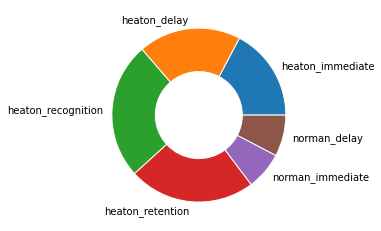

In [12]:
fig, ax = plt.subplots(1,1)
ax.pie(mem_domain._weights,
       labels = mem_domain._weights.index,
       wedgeprops=dict(width=0.5, edgecolor='w'))
mem_domain._weights

In [13]:
cols = ['heaton_immediate', 'heaton_retention',
        'heaton_delay', 'heaton_recognition', 'aggregated_score',
        'norman_immediate', 'norman_delay', 'age', 'gender', 'race', 'education']
mem_domain.data[cols].reset_index().to_excel('processed_memory.xlsx', index=False)

Beyond the memory domain there is also the Executive Function domain.
This seems to be mainly using the Trails Making Test and the Stroop Word Test.

Currently only the Stroop test is implemented using the Norman regression based norms.

In [14]:
#export

class ExecutiveFunctionDomain(AbstractDomain):


    @staticmethod
    def from_defaults(root_data = 'data/'):

        norman_regression_definition = os.path.join(root_data, 'norms/norman/norman_stroop_regnorm.yaml')
        reg_calc = TestCalculator.from_config(yaml.full_load(open(norman_regression_definition)))

        full_exec_calc = reg_calc
        final_fields = ['norman_stroop_color', 'norman_stroop_word', 'norman_stroop_color_word']

        return ExecutiveFunctionDomain(full_exec_calc, final_fields)

In [15]:
ex_fun_domain = ExecutiveFunctionDomain.from_defaults()
ex_fun_domain.load_data(all_neuro, mapping=COLUMN_MAPPING)

ex_fun_domain.data.tail()

age  education  gender race  stroop_color  \
VisitDate  PatientID                                              
2020-02-27 B0551       58         20    male   AA           0.0   
           B0742       41         11    male   AA          48.0   
2020-03-03 B0639       65         12  female   AA          60.0   
2020-03-04 B0388       67         11  female   AA          68.0   
2020-03-05 B0303       58         11    male   AA          37.0   

                      stroop_color_word  stroop_word  norman_gender  \
VisitDate  PatientID                                                  
2020-02-27 B0551                    0.0         74.0            0.0   
           B0742                   35.0         69.0            0.0   
2020-03-03 B0639                   36.0         99.0            1.0   
2020-03-04 B0388                   35.0         80.0            1.0   
2020-03-05 B0303                   11.0         72.0            0.0   

                      norman_race  stroop_color_scaled  \
VisitDate  PatientID                                     
2020-02-27 B0551              1.0                  2.0   
           B0742              1.0                  4.0   
2020-03-03 B0639              1.0                  6.0   
2020-03-04 B0388              1.0                  8.0   
2020-03-05 B0303              1.0                  2.0   

                      stroop_color_word_scaled  stroop_word_scaled  \
VisitDate  PatientID                                                 
2020-02-27 B0551                           3.0                 5.0   
           B0742                           7.0                 4.0   
2020-03-03 B0639                           8.0                 9.0   
2020-03-04 B0388                           7.0                 6.0   
2020-03-05 B0303                           3.0                 5.0   

                      norman_stroop_color  norman_stroop_color_word  \
VisitDate  PatientID                                                  
2020-02-27 B0551                -2.405817                 -1.663188   
           B0742                -1.249190                  0.126202   
2020-03-03 B0639                -0.268558                  0.894761   
2020-03-04 B0388                      NaN                       NaN   
2020-03-05 B0303                -1.357962                 -0.724579   

                      norman_stroop_word  aggregated_score  
VisitDate  PatientID                                        
2020-02-27 B0551               -1.418256         -1.824023  
           B0742               -1.159039         -0.750434  
2020-03-03 B0639                0.793249          0.481324  
2020-03-04 B0388                     NaN               NaN  
2020-03-05 B0303               -0.280097         -0.783344

In [16]:

norman_color_color_word_fig = ex_fun_domain.build_scatter_fig(x = 'norman_stroop_color',
                                                           y = 'norman_stroop_color_word',
                                                           fig=FIG_SIZE)

norman_color__word_fig = ex_fun_domain.build_scatter_fig(x = 'norman_stroop_color',
                                                      y = 'norman_stroop_word',
                                                      fig=FIG_SIZE)

norman_color_word_word_fig = ex_fun_domain.build_scatter_fig(x = 'norman_stroop_color_word',
                                                          y = 'norman_stroop_word',
                                                          fig=FIG_SIZE)

show(layout([[norman_color_color_word_fig],
             [norman_color__word_fig, norman_color_word_word_fig]]))

norman_stroop_color         0.326351
norman_stroop_word          0.332837
norman_stroop_color_word    0.340812
dtype: float64

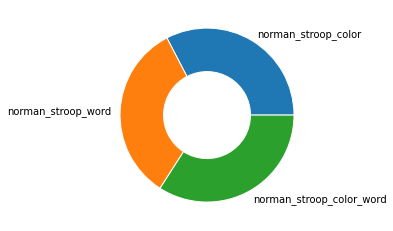

In [17]:
fig, ax = plt.subplots(1,1)
ax.pie(ex_fun_domain._weights,
       labels = ex_fun_domain._weights.index,
       wedgeprops=dict(width=0.5, edgecolor='w'))
ex_fun_domain._weights

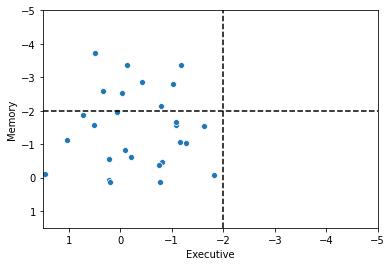

In [18]:
fig, ax = plt.subplots(1,1)

sbn.scatterplot(ex_fun_domain.data['aggregated_score'],
                mem_domain.data['aggregated_score'],
                ax = ax)

ax.set_ylabel('Memory')
ax.set_xlabel('Executive')
ax.set_xlim(1.5, -5)
ax.set_ylim(1.5, -5)
ax.axvline(-2, linestyle = '--', color = 'k')
ax.axhline(-2, linestyle = '--', color = 'k')